# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal


### Projet A2025

----
### Contexte
Le béton est le matériau le plus important en génie civil. La résistance à la compression du béton est une fonction fortement non linéaire de son âge et de ses constituants. Ces constituants comprennent le ciment, le laitier de haut fourneau, les cendres volantes, l’eau, le superplastifiant, les gros granulats et les granulats fins.

Vous avez accès à une vraie banque de données répertoriant la résistance à la compression du béton en fonction de ses constituants. Ces données ont déjà été analysées avec des réseaux de neurones dans plusieurs articles scientifiques, notamment Chen (1998).

### Objectif
L'objectif principal est de développer un modèle statistique permettant la prédiction de la résistance à la compression (**Strength**) des 330 recettes de l'ensemble de test, en fonction de leurs caractéristiques et de leur âge.

### Description des Données
Les données sont réparties en deux fichiers :
- `train.csv` : 700 recettes avec la résistance connue (Ensemble d'entraînement).
- `test.csv` : 330 recettes dont la résistance est à prédire.

# **1. Chargement des données**
Importation des librairies nécessaires à l'analyse et à la modélisation.

In [12]:
using CSV, DataFrames, Statistics, Plots, LinearAlgebra, Random, Measures

default(size=(800, 500), margin=5Plots.mm)

## 1.1 Chargement des données d'entraînement et de test
Nous chargeons les fichiers CSV dans des DataFrames pour faciliter la manipulation.

In [13]:
train_df = CSV.read("data/train.csv", DataFrame)
test_df = CSV.read("data/test.csv", DataFrame)

println("Dimensions Train : ", size(train_df))
println("Dimensions Test  : ", size(test_df))

first(train_df, 5)

Dimensions Train : (700, 10)
Dimensions Test  : (330, 9)


5×10 DataFrame
 Row │ ID     Cement   Slag     Ash      Water    Superplasticizer  Coarse   F ⋯
     │ Int64  Float64  Float64  Float64  Float64  Float64           Float64  F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1    102.0    153.0      0.0    192.0               0.0    887.0    ⋯
   2 │     2    153.0    102.0      0.0    192.0               0.0    888.0
   3 │     3    141.3    212.0      0.0    203.5               0.0    971.8
   4 │     4    183.9    122.6      0.0    203.5               0.0    959.2
   5 │     5    385.0      0.0      0.0    186.0               0.0    966.0    ⋯
                                                               3 columns omitted

## 1.2 Vérification de la qualité des données
Nous vérifions s'il existe des valeurs manquantes qui pourraient fausser l'analyse. Nous voyons qu'il n'y a aucune donnée manquante. (nmissing = 0 pour toutes les variables)

In [3]:
describe(train_df)

10×7 DataFrame
 Row │ variable          mean       min     median   max     nmissing  eltype  ⋯
     │ Symbol            Float64    Real    Float64  Real    Int64     DataTyp ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID                350.5        1       350.5   700           0  Int64   ⋯
   2 │ Cement            283.868    102.0     277.0   540.0         0  Float64
   3 │ Slag               74.8664     0.0      24.0   359.4         0  Float64
   4 │ Ash                53.7016     0.0       0.0   200.0         0  Float64
   5 │ Water             181.207    121.8     185.0   246.9         0  Float64 ⋯
   6 │ Superplasticizer    6.24386    0.0       6.5    32.2         0  Float64
   7 │ Coarse            973.72     801.0     968.0  1145.0         0  Float64
   8 │ Fine              772.727    594.0     778.5   992.6         0  Float64
   9 │ Age                44.9        1        28.0   365           0  Int64   ⋯
  10 │ Strength           36.3293     4.57     35.2    82.6         0  Float64
                                                                1 column omitted

----


# **2. Exploration des données**




Avant de commenecr la modélisation, la visualisation des données constitue une étape essentielle pour comprendre la structure du jeu de données et identifier les relations potentielles entre variables. 

En particulier, cette démarche nous permet de repérer d’éventuelles tendances, des zones de dispersion ou regroupements naturels. Cela nous permet d'avoir un premier aperçu des mécanismes susceptibles d’influencer la variable cible. 

### **2.1 Visualisation de chaque feature en fonction de la variable cible**




Nous commençons par examiner la distribution de chaque feature en fonction de la variable cible. Ceci nous permet d’identifier la nature des relations qui les lient : linéaires, non linéaires  ou au contraire inexistantes. 

L'idée ici est de récupérer le plus d'informations sur des zones de variabilité différentielle, des seuils possibles, ou alors des comportements atypiques pouvant influencer la performance du modèle. Autrement dit, cette analyse nous permet de mieux anticiper la pertinence prédictive de chaque variable etde détecter d’éventuelles transformations nécessaires (normalisation, logarithme, etc.).

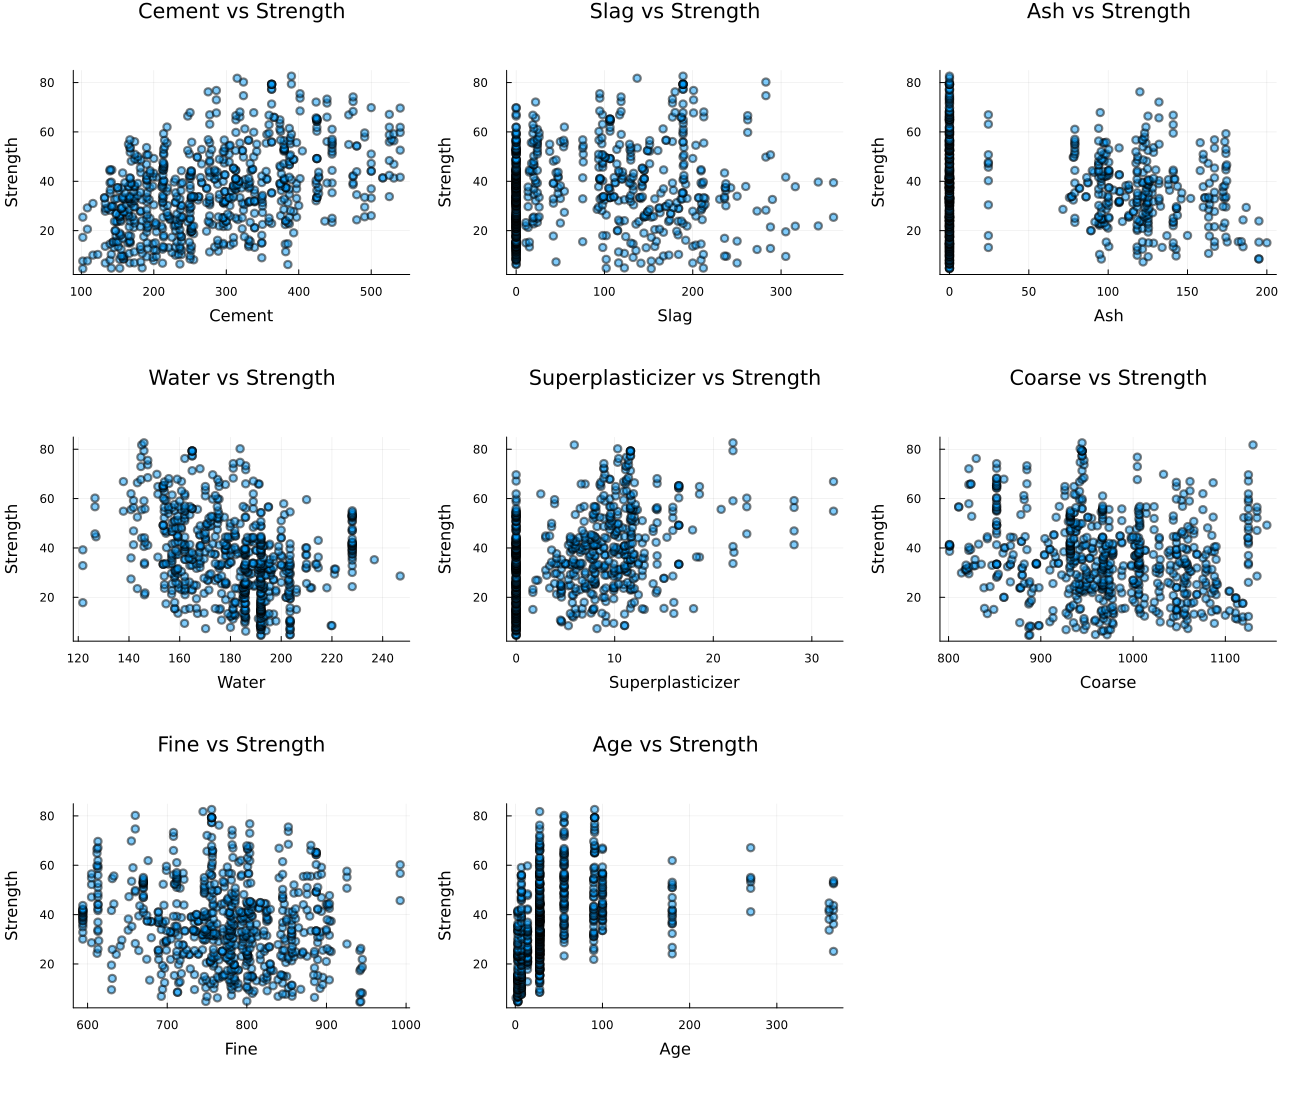

In [12]:
function plot_features_vs_target(train_df, target_col)
    features = names(train_df)[2:end-1]  # pour exclure ID et Strength
    n_features = length(features)
    
    plots = []    
    for feature in features
        p = scatter(train_df[!, feature], train_df[!, target_col],
                  xlabel=feature, ylabel=target_col,
                  title="$feature vs $target_col",
                  markersize=4, alpha=0.5,
                  legend=false)
        push!(plots, p)
    end

    plot_grid = plot(plots..., layout=(ceil(Int, n_features/3), 3), size=(1300, 1100),
                   left_margin=4mm,
                   right_margin=4mm,
                   top_margin=10mm,
                   bottom_margin=10mm)
    display(plot_grid)
end

plot_features_vs_target(train_df, "Strength")

Pour analyser de plus près les différentes tendances, on analyse la corrélation de chque attribut avec la variable cible.


Corrélations avec Strength (triées) :
Cement: 0.462
Superplasticizer: 0.419
Age: 0.336
Slag: 0.143
Ash: -0.071
Fine: -0.16
Coarse: -0.167
Water: -0.308


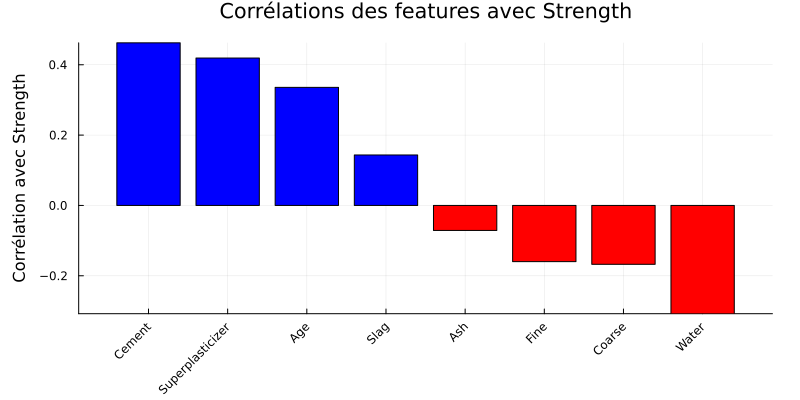

In [ ]:
function analyze_strength_correlations(train_df)
    features = names(train_df)[2:end-1] 
    correlations = Float64[]    
    for feature in features
        cor_val = cor(train_df[!, feature], train_df.Strength)
        push!(correlations, cor_val)
    end
    
    cor_df = DataFrame(Feature=features, Correlation=correlations)
    sort!(cor_df, :Correlation, rev=true)
    
    println("\nCorrélations avec Strength (triées) :")
    for row in eachrow(cor_df)
        println("$(row.Feature): $(round(row.Correlation, digits=3))")
    end
    
    # graphique des corrélations
    bar_plot = Plots.bar(cor_df.Feature, cor_df.Correlation,
        xlabel="Features", ylabel="Corrélation avec Strength",
        title="Corrélations des features avec Strength",
        legend=false, xrotation=45,
        color=ifelse.(cor_df.Correlation .> 0, :blue, :red),
        size=(800, 400))
    
    
    return bar_plot
end

cor_bar_plot = analyze_strength_correlations(train_df)

### **2.2 Interprétation des relations : Composants vs. Strength**

En examinant les diagrammes de dispersion pour chaque variable explicative, nous tirons les observations suivantes concernant leur relation avec la **Force (Strength)** du béton :

| Variable | Type relation avec Force | Tendances clés |
| :--- | :--- | :--- |
| **Ciment** | Corrélation positive | Augmentation de la Force en moyenne avec l'augmentation du Ciment. La dispersion verticale (variation de la Force) est assez large pour la plupart des niveaux de Ciment|
| **Age** | Corrélation positive | Augmentation de la Force significative avec l'augmentation de l'Âge (jusqu'à environ 100 jours). |
| **Water** | Corrélation négative modérée | Diminution de la Force en moyenne avec l'augmentation de la quantité d'Eau. |
| **Slag** | Complexe / non-linéaire | Dispersion élevée, les Forces les plus élevées sont atteintes à des valeurs de Slag faibles à modérées. |
| **Ash** | Faible / nulle | Très forte dispersion, les Forces les plus élevées sont atteintes uniquement lorsque l'Ash est faible. |
| **Superplasticizer** | Complexe / non-linéaire | Forte concentration à zéro, les Forces les plus élevées sont atteintes à des doses faibles à modérées (entre 5 et 20). |
| **Fine** | Faible / légèrement négative | Très forte dispersion sans tendance claire. |
| **Coarse** | Nulle | Très forte dispersion sans tendance claire. |








#### Dégagement d'une première piste de recherche grâce à cette visualisation : vers le Feature Engineering

##### 1. Création de variables booléennes :

L'analyse des distributions des varaibles **Slag, Ash et Superplasticizer** révèle une caractéristique commune notable : une **concentration élevée de valeurs à zéro** sur l'axe des x. Cette masse de points à l'origine suggère qu'une portion significative des recettes de béton enregistrées n'inclut pas ces additifs. 
* Ainsi, les variables avec une forte concentration de valeurs à zéro masquent une information binaire cruciale : la recette inclut-elle l'additif ou non ?
Cette observation nous donne une première piste de réflexion : au  lieu de considérer uniquement la quantité continue de ces attributs, il pourrait être très pertinent de **les transformer en variables booléennes** (ou binaires).

##### 2. Variables indiquant un besoin de transformation (non-linéarité) :

Pour **apréhender la modélisation des relations complexes** comme celle de l'âge avec la force, nous devons appliquer des **transformations non linéaires**. L'objectif est de rendre ces relations plus linéaires si nous voulons utiliser des algorithmes classiques par la suite.

* Pour l'Âge, dont l'effet diminue avec le temps (saturation), la méthode la plus appropriée est la transformation logarithmique ($\ln(\text{Âge})$) : elle compresse les grandes valeurs et étire les petites, normalisant ainsi le taux de gain de Force. Une autre approche clé est la discrétisation (Binning), qui consiste à segmenter la variable en intervalles, ce qui pourrait permettre au modèle de mieux apprendre les différents paliers de prise de Force spécifiques aux normes de construction. 

* Les transformations polynomiales (ex : $X^2$) peuvent être utiles pour capturer des courbures subtiles ou alors des effets de seuil dans des variables comme le ciment. 

On explorera ces différentes pistes par la suite.

### **2.3 Détection des valeurs suspectes**

La présence de données aberrantes (*outliers*) peut gravement nuire à la qualité d'un modèle de régression, car la méthode des moindres carrés est très sensible aux valeurs extrêmes.

Comme vu au **Chapitre 2 (Section 2.7.5 - Identification des données suspectes)**, nous utilisons les **résidus studentisés** ($s_i$) pour identifier ces observations.

#### 2.3.1 Méthodologie Théorique

Le résidu studentisé interne est défini par :
$$s_i = \frac{e_i}{\sqrt{\hat{\sigma}^2 (1 - h_i)}}$$

Où :
* $e_i = y_i - \hat{y}_i$ est le résidu ordinaire.
* $\hat{\sigma}^2$ est l'estimateur sans biais de la variance de l'erreur (**Chapitre 2, Éq 2.4**).
* $h_i$ est le levier de l'observation $i$ (élément diagonal de la matrice chapeau $H = X(X^\top X)^{-1}X^\top$).

**Critère de rejet :** Une observation est considérée comme suspecte si $|s_i| > 3$ (**Chapitre 2.7.5**).

#### 2.3.2 Implémentation Manuelle
Nous implémentons le calcul matriciel "from scratch" pour démontrer notre compréhension des équations du cours.

Nombre d'outliers détectés (|s_i| > 3) : 2
Indices des observations à retirer : [188, 699]


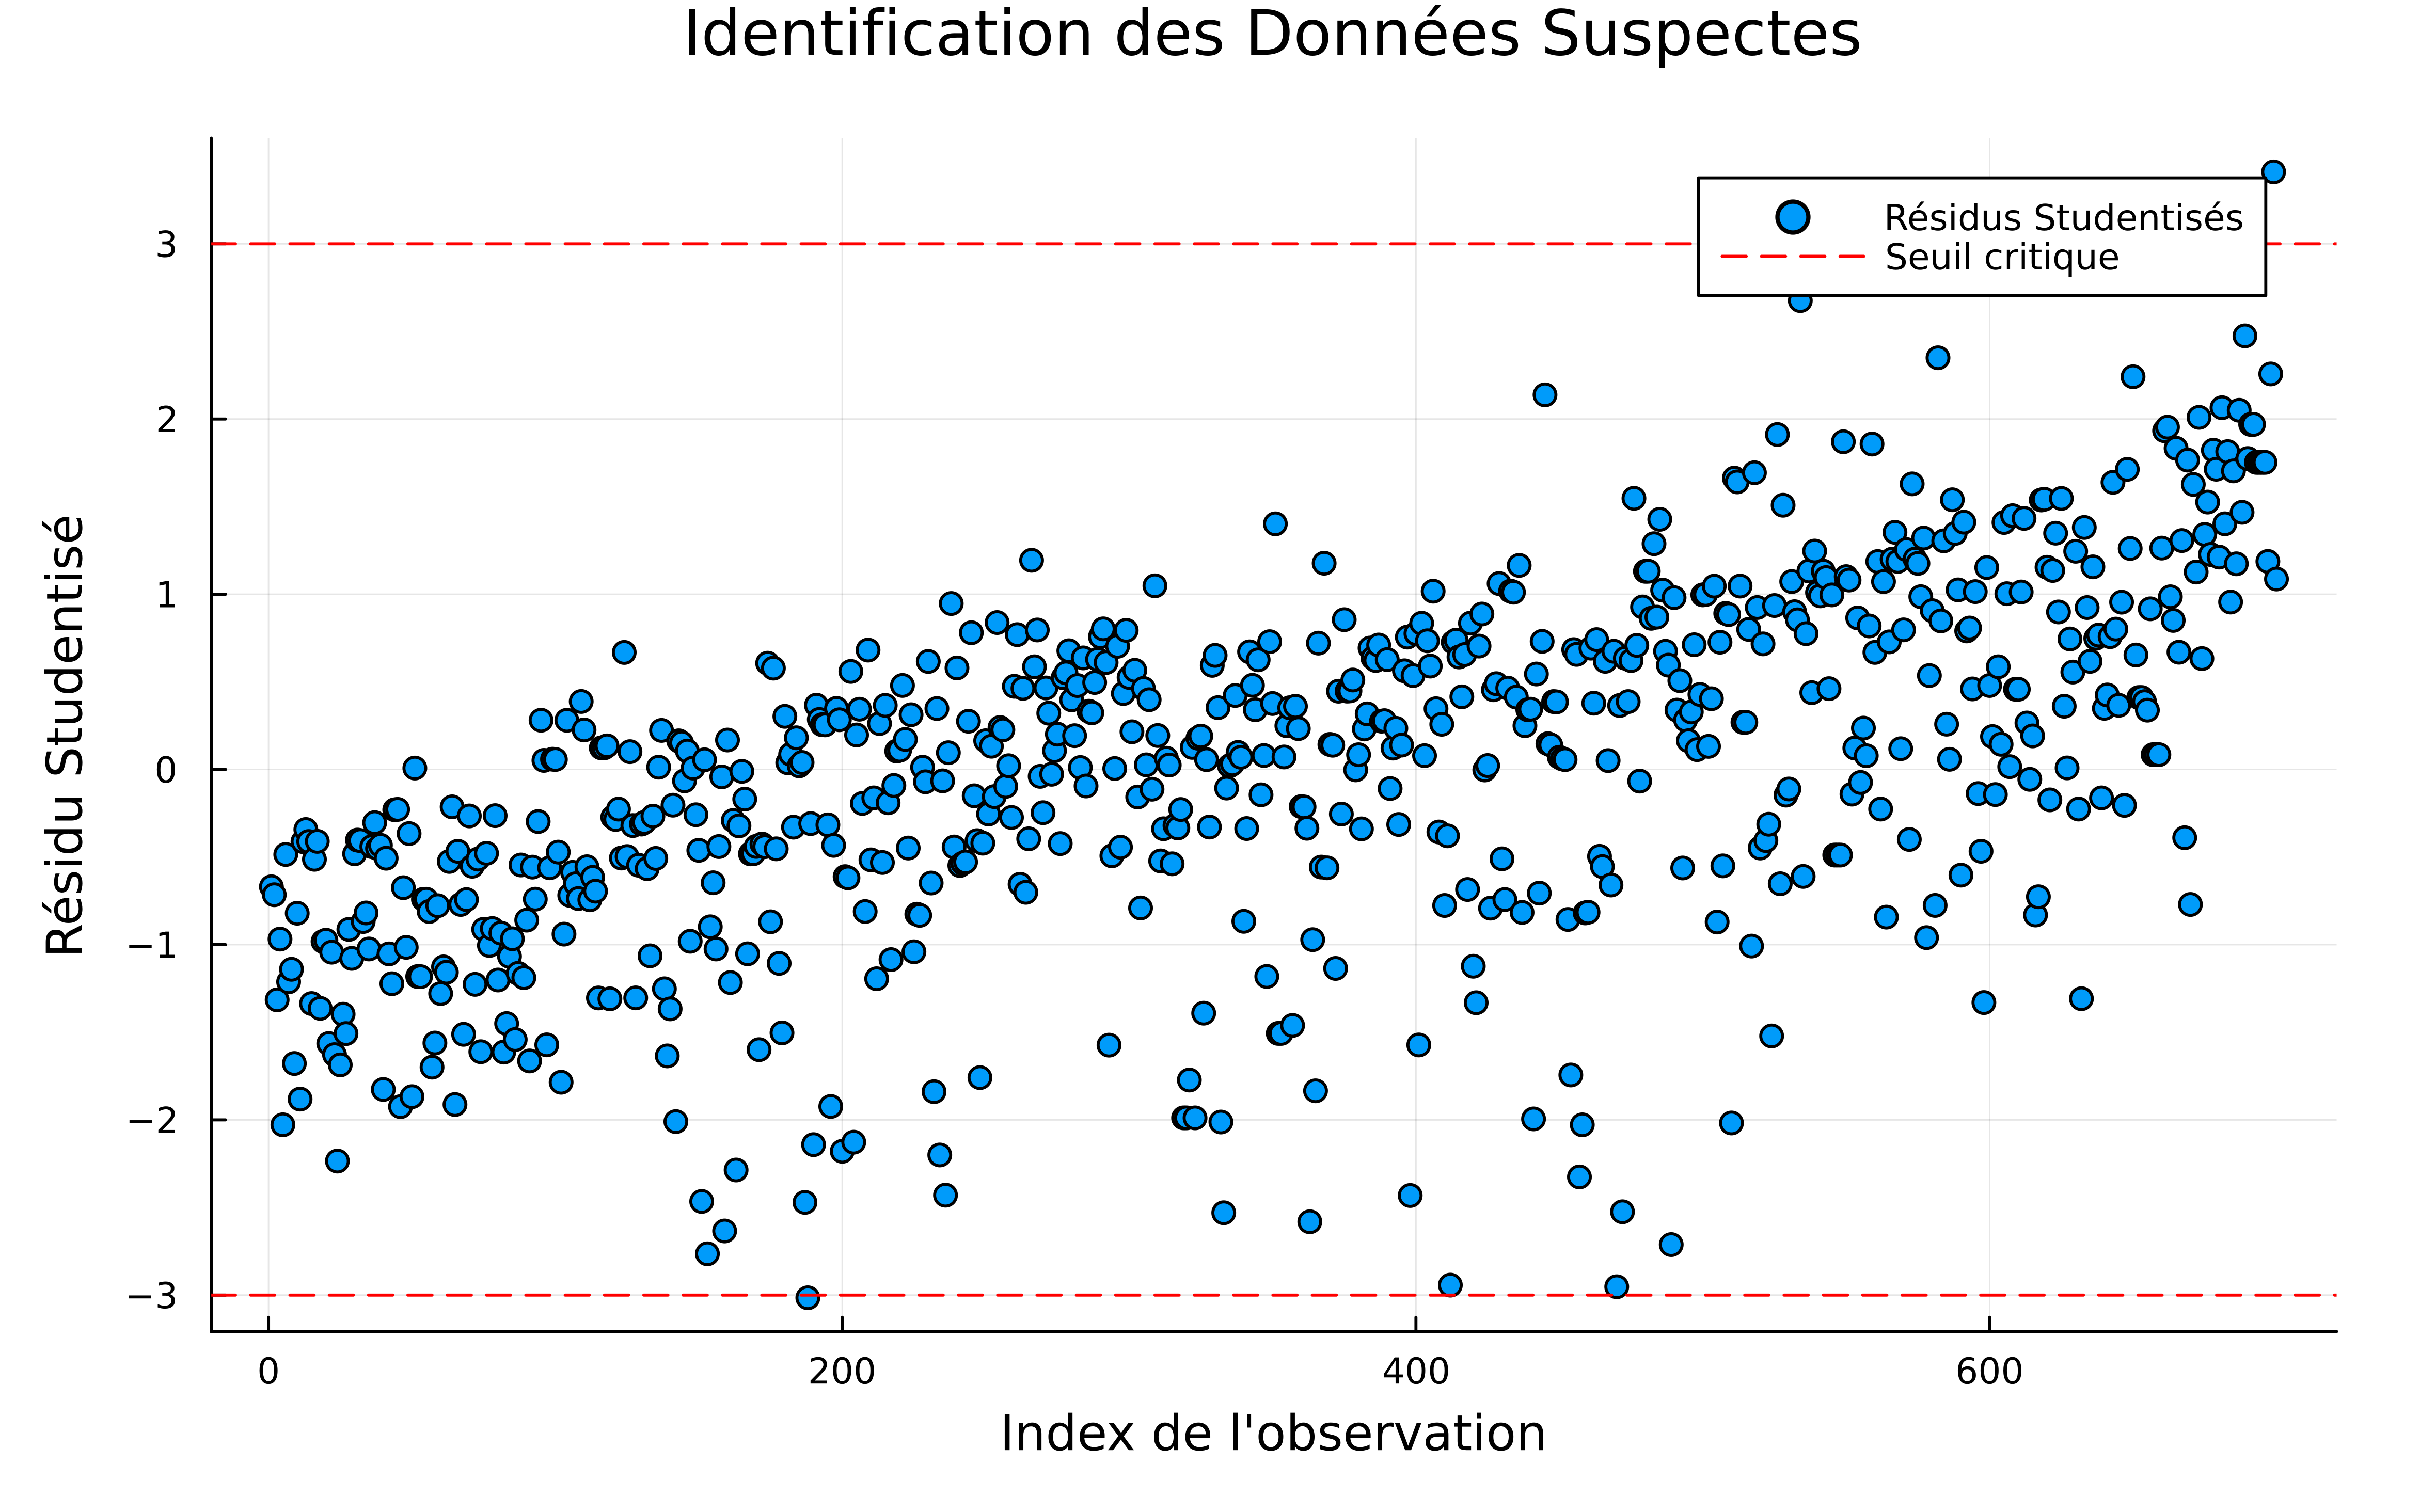

In [4]:
# fonction pour calculer les résidus studentisés
function detect_outliers(X, y)
    X_mat = Matrix(X)
    n, p = size(X_mat)
    
    X_design = hcat(ones(n), X_mat) 

    beta_hat = (X_design' * X_design) \ (X_design' * y) # estimation des coefficients (MCO)
    
    y_hat = X_design * beta_hat
    residuals = y - y_hat
    
    n, p_design = size(X_design)
    sigma2_hat = sum(residuals.^2) / (n - p_design)
    
    XtX_inv = inv(X_design' * X_design)
    h = [ (X_design[i,:]' * XtX_inv * X_design[i,:]) for i in 1:n ]
    
    studentized = residuals ./ sqrt.(sigma2_hat .* (1 .- h))
    
    return studentized
end

features_cols = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
X_check = train_df[:, features_cols]
y_check = train_df.Strength

residus_stud = detect_outliers(X_check, y_check)

# Identification des indices dépassant le seuil critique de 3
outliers_indices = findall(abs.(residus_stud) .> 3)

println("Nombre d'outliers détectés (|s_i| > 3) : ", length(outliers_indices))
println("Indices des observations à retirer : ", outliers_indices)

# Visualisation
scatter(residus_stud, label="Résidus Studentisés", legend=:topright,
        title="Identification des Données Suspectes", 
        xlabel="Index de l'observation", ylabel="Résidu Studentisé")
hline!([3, -3], color=:red, linestyle=:dash, label="Seuil critique")

#### 2.3.3 Suppression des observations aberrantes

Suite à l'analyse graphique et au critère $|s_i| > 3$, nous retirons ces observations de l'ensemble d'entraînement. Ces points risquent de correspondre à des erreurs de mesure ou à des bétons aux propriétés exceptionnelles non représentatives de la population générale. Les conserver risquerait de biaiser notre modèle, particulièrement lors de l'utilisation de polynômes de degré élevé.

In [14]:
# Création du jeu de données nettoyé
df_train_clean = train_df[setdiff(1:nrow(train_df), outliers_indices), :]

println("Taille initiale : ", size(train_df))
println("Taille après nettoyage : ", size(df_train_clean))

Taille initiale : (700, 10)
Taille après nettoyage : (698, 10)


### **2.4 Détection et traitement des doublons**
Après avoir inspecté les données, nous avons remarqué que certaines "recettes" de béton apparaissent plusieurs fois dans le jeu de données d'entraînement.

**Pourquoi est-ce problématique ?**
1.  **Biais du modèle :** Si une recette est présente en double, le modèle lui accordera artificiellement plus d'importance lors de l'apprentissage, ce qui fausse la minimisation de l'erreur.
2.  **Fuite de données (Data Leakage) :** Lors de la validation croisée, si une copie se trouve dans l'ensemble d'entraînement et l'autre dans l'ensemble de validation, le score de validation sera artificiellement gonflé (le modèle "connaît" déjà la réponse), mais la performance réelle sur le test set sera décevante.

Nous allons donc identifier et supprimer ces doublons exacts en excluant la colonne `ID` (qui est unique par définition) pour comparer uniquement les caractéristiques physico-chimiques et la résistance.


In [15]:
cols_features = names(df_train_clean, Not(:ID))
doublons_mask = nonunique(df_train_clean, cols_features)
nb_doublons = sum(doublons_mask)


gdf = groupby(train_df, cols_features)
groupes_doublons = filter(x -> nrow(x) > 1, gdf)
display(first(DataFrame(groupes_doublons), 5))

original_size = size(df_train_clean, 1)
train_df_unique = unique(df_train_clean, cols_features)
new_size = size(train_df_unique, 1)

println("Taille initiale : ", original_size)
println("Taille après nettoyage des doublons : ", new_size)
print("Nombre de doublons: ", nb_doublons)

5×10 DataFrame
 Row │ ID     Cement   Slag     Ash      Water    Superplasticizer  Coarse   F ⋯
     │ Int64  Float64  Float64  Float64  Float64  Float64           Float64  F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   116    252.0      0.0      0.0    185.0               0.0   1111.0    ⋯
   2 │   117    252.0      0.0      0.0    185.0               0.0   1111.0
   3 │   319    425.0    106.3      0.0    153.5              16.5    852.1
   4 │   320    425.0    106.3      0.0    153.5              16.5    852.1
   5 │   323    425.0    106.3      0.0    153.5              16.5    852.1    ⋯
                                                               3 columns omitted

Taille initiale : 698
Taille après nettoyage des doublons : 684
Nombre de doublons: 14

### **2.5 Fusion des Quasi-Doublons**

En inspectant les données (par exemple les IDs 226 et 227), nous avons remarqué des lignes avec une résistance identique mais des ingrédients variant infimement (ex: 158.6 vs 159.0). Cela suggère des erreurs d'arrondi ou des variations minimes lors de la saisie des données.

Pour rendre le modèle plus robuste et réduire ce "bruit", nous regroupons les lignes qui sont identiques à l'arrondi près (entier le plus proche) et nous les remplaçons par une ligne unique contenant la moyenne de leurs valeurs.

In [16]:
cols_features = names(train_df_unique, Not([:ID, :Strength]))

train_df_temp = copy(train_df_unique)
for col in cols_features
    train_df_temp[!, Symbol(col, "_rounded")] = round.(train_df_unique[!, col], digits=0)
end

cols_rounded = [Symbol(c, "_rounded") for c in cols_features]
gdf = groupby(train_df_temp, cols_rounded)

groupes_doublons = filter(g -> nrow(g) > 1, gdf)

nb_lignes_concernees = sum(nrow(g) for g in groupes_doublons)


df_show = DataFrame(groupes_doublons)
sort!(df_show, cols_rounded)

println("Aperçu des paires :")
display(first(select(df_show, names(train_df_unique)), 10))

cols_to_average = names(train_df_unique, Not(:ID))

ops = vcat( [:ID => first => :ID], cols_to_average .=> mean .=> cols_to_average )

train_df_fused = combine(gdf, ops...)

select!(train_df_fused, names(train_df_unique))

println("Taille avant  : ", size(train_df_unique, 1))
println("Taille après  : ", size(train_df_fused, 1))

Aperçu des paires :


10×10 DataFrame
 Row │ ID     Cement   Slag     Ash      Water    Superplasticizer  Coarse   F ⋯
     │ Int64  Float64  Float64  Float64  Float64  Float64           Float64  F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   240    133.1    210.2      0.0    195.7               3.1    949.4    ⋯
   2 │   268    133.0    210.0      0.0    196.0               3.0    949.0
   3 │   219    147.8    175.1      0.0    171.2               2.2   1000.0
   4 │   220    148.0    175.0      0.0    171.0               2.0   1000.0
   5 │   388    150.0    237.0      0.0    174.0              12.0   1069.0    ⋯
   6 │   389    150.0    236.8      0.0    173.8              11.9   1069.3
   7 │   201    153.1    145.0    113.0    178.5               8.0   1001.9
   8 │   202    153.0    145.0    113.0    178.0               8.0   1002.0
   9 │    19    158.4      0.0    194.9    219.7              11.0    897.7    ⋯
  10 │    20    158.0      0.0    195.0    220.0              11.0    898.0
                                                               3 columns omitted

Taille avant  : 684
Taille après  : 642


ajout de la transition vers la prochaine partie

---

# **3. Etude de la multicolinéarité**

Après l’exploration visuelle des données, il est essentiel d’évaluer la présence éventuelle de multicolinéarité entre les variables explicatives. En effet, lorsque plusieurs features sont fortement corrélées entre elles, elles peuvent apporter une information redondante, fausser l’interprétation des relations avec la variable cible et dégrader la stabilité des modèles prédictifs.

Ainsi, pour anticiper **les besoins de robustesse et d'interprétabilité** des modèles que nous allons réaliser, il est nécessaire d'étudier la présence éventuelle de **multicolinéarité** permi nos variables explicatives. Détecter ces dépendances permet d’anticiper la nécessité d’une réduction dimensionnelle, d’un choix plus judicieux de variables ou même de l'ajout d’une régularisation adaptée.

### 3.1 Matrice de corrélation

Pour obtenir une première compréhension structurelle du comportement des variables de notre jeu de données, nous avons établi une **matrice de corrélation**. 

Cet outil nous permet d’identifier rapidement les relations linéaires entre les différentes caractéristiques. En particulier, la matrice de corrélation fournit une indication sur **la présence potentielle de multicolinéarité**, c’est-à-dire de variables fortement corrélées entre elles qui seraient susceptibles de dégrader la stabilité ou l’interprétabilité d’un modèle prédictif. 


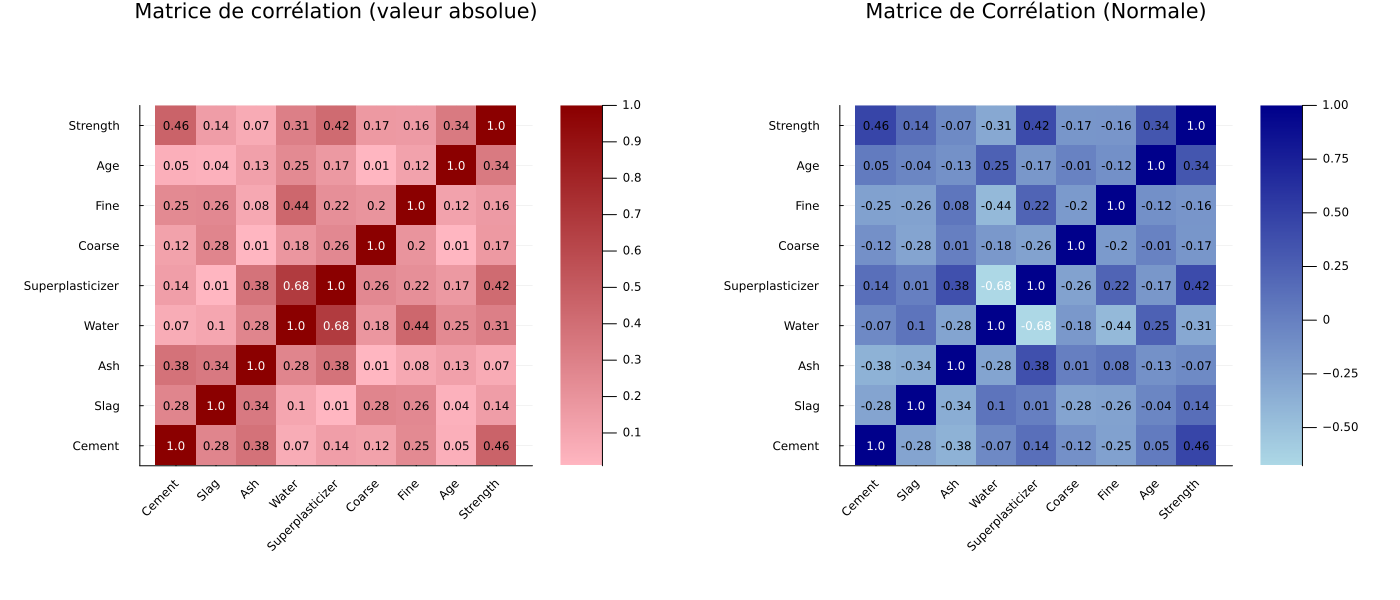

In [ ]:
function create_correlation_heatmap(cor_matrix::Matrix, numeric_cols::Vector{String}, plot_title::String, color_palette::Symbol)
    
    num_vars = length(numeric_cols)

    heatmap_obj = Plots.heatmap(cor_matrix,
           xticks=(1:num_vars, numeric_cols),
           yticks=(1:num_vars, numeric_cols),
           color=color_palette,
           aspect_ratio=:equal,
           title=plot_title,
           xrotation=45,
           size=(400, 350)) 
           
    for i in 1:size(cor_matrix, 1)
        for j in 1:size(cor_matrix, 2)
            text_color = abs(cor_matrix[i, j]) > 0.5 ? :white : :black
            
            Plots.annotate!(heatmap_obj, j, i, Plots.text(round(cor_matrix[i, j], digits=2), 8, text_color))
        end
    end
    
    return heatmap_obj

end

function plot_side_by_side_correlation(train_df::DataFrame)
    
    numeric_cols = names(train_df)[2:end]
    numeric_df = train_df[:, numeric_cols]
    cor_matrix = cor(Matrix(numeric_df))
    abs_cor_matrix = abs.(cor_matrix)
    

    abs_corr_plot = create_correlation_heatmap(abs_cor_matrix,numeric_cols,"Matrice de corrélation (valeur absolue)", :reds )

    corr_plot = create_correlation_heatmap(
        cor_matrix,
        numeric_cols,
        "Matrice de Corrélation (Normale)",
        :blues
    )

    final_plot = Plots.plot(abs_corr_plot, corr_plot, layout=(1, 2), size=(1400, 600))
    
    return final_plot
end

final_corr_plot = plot_side_by_side_correlation(train_df)
display(final_corr_plot)

### Risque de multicolinéarité


| Variables Liées | Corrélation (Absolue) | Risque et Conséquence |
| :--- | :--- | :--- |
| **Water** vs. **Superplasticizer** | **0.68** | **Risque élevé.** Le Superplasticizer est utilisé pour **réduire** l'eau (**Corrélation Négative de -0.68**). Un modèle linéaire aura du mal à isoler l'effet de chacun. |
| **Water** vs. **Fine** | 0.44 | Risque modéré |
| **Ash** vs. **Superplasticizer** | 0.38 | Risque modéré |
| **Ash** vs. **Cement** | 0.38 | Risque modéré |




In [11]:
using CSV, DataFrames, LinearAlgebra, Statistics, Random

# ==========================================
# PARTIE 1 : ALGORITHMES 
# ==========================================

# --- A. Mise à l'échelle (Robust Scaler manuel) ---
# On centre sur la médiane et on divise par l'écart interquartile (IQR)
struct ManualScaler
    medians::Vector{Float64}
    iqrs::Vector{Float64}
end

function fit_scaler(X::Matrix)
    medians = vec(median(X, dims=1))
    # IQR = p75 - p25
    q25 = vec(map(col -> quantile(col, 0.25), eachcol(X)))
    q75 = vec(map(col -> quantile(col, 0.75), eachcol(X)))
    iqrs = q75 .- q25
    # Éviter la division par zéro
    iqrs[iqrs .== 0] .= 1.0
    return ManualScaler(medians, iqrs)
end

function transform_scale(scaler::ManualScaler, X::Matrix)
    return (X .- scaler.medians') ./ scaler.iqrs'
end

# --- B. Feature Engineering "Polynomial" Manuel ---
# Crée les termes quadratiques (x^2) et interactions (x*y)
function expand_poly(X::Matrix)
    n_samples, n_features = size(X)
    
    # On veut : Original + Carrés + Cubes + Interactions
    # (Degree 3 "Light")
    
    # Pré-allocation (Approximative)
    n_out = n_features * 3 + (n_features * (n_features - 1)) ÷ 2
    X_poly = zeros(n_samples, n_out)
    
    col = 1
    
    # 1. Termes originaux (x)
    X_poly[:, col:col+n_features-1] = X
    col += n_features
    
    # 2. Carrés (x^2)
    X_poly[:, col:col+n_features-1] = X .^ 2
    col += n_features
    
    # 3. Cubes (x^3) -> L'AJOUT CLÉ POUR BATTRE LE 4.7
    X_poly[:, col:col+n_features-1] = X .^ 3
    col += n_features
    
    # 4. Interactions (x * y)
    for i in 1:n_features
        for j in i+1:n_features
            X_poly[:, col] = X[:, i] .* X[:, j]
            col += 1
        end
    end
    
    # Ajout du Biais
    return hcat(ones(n_samples), X_poly[:, 1:col-1])
end
# --- C. Régression Bayésienne (Algorithme "Evidence Approximation") ---
# C'est l'algo exact utilisé pour  BayesianRidge
function fit_bayesian_ridge(X, y; max_iter=300, tol=1e-3)
    n_samples, n_features = size(X)
    
    # Initialisation de alpha (précision du bruit) et lambda (précision des poids)
    alpha = 1.0 / var(y)
    lambda = 1.0
    
    XT_X = X' * X
    XT_y = X' * y
    
    w = zeros(n_features)
    eigen_vals = eigen(Symmetric(XT_X)).values # Valeurs propres pour optimiser le calcul
    
    for i in 1:max_iter
        # 1. Calcul de la Matrice de Covariance A posteriori (Sigma)
        # S^-1 = lambda * I + alpha * X^T * X
    
        A = lambda * I(n_features) + alpha * XT_X
        
        # 2. Calcul de la moyenne (w) : w = alpha * S * X^T * y
        # Résolution du système linéaire A * w = alpha * XT_y
        w_old = copy(w)
        w = A \ (alpha * XT_y)
        
        # 3. Mise à jour de gamma (nombre effectif de paramètres)
        # gamma = sum( (alpha * eig) / (lambda + alpha * eig) )
        gamma = sum((alpha .* eigen_vals) ./ (lambda .+ alpha .* eigen_vals))
        
        # 4. Mise à jour des hyperparamètres alpha et lambda
        # lambda = gamma / (w^T * w)
        lambda = gamma / (dot(w, w) + 1e-6)
        
        # alpha = (N - gamma) / sum((y - Xw)^2)
        residuals = y - X * w
        alpha = (n_samples - gamma) / (dot(residuals, residuals) + 1e-6)
        
        # Convergence ?
        if norm(w - w_old) < tol
            break
        end
    end
    
    return w
end

# --- D. GMM Simplifié (K-Means + Softmax) ---
# Pour simuler les variables latentes sans package lourd
function get_latent_probs(X_train, X_test, n_clusters; seed=42)
    Random.seed!(seed)
    n_samples = size(X_train, 1)
    
    # 1. Init: Choix aléatoire des centres
    centers = X_train[randperm(n_samples)[1:n_clusters], :]
    
    # 2. K-Means simplifié (10 itérations suffisent pour l'initialisation)
    for _ in 1:10
        # Assignation
        dists = [norm(X_train[i,:] - centers[k,:])^2 for i in 1:n_samples, k in 1:n_clusters]
        labels = [argmin(dists[i,:]) for i in 1:n_samples]
        
        # Update centers
        for k in 1:n_clusters
            mask = labels .== k
            if sum(mask) > 0
                centers[k,:] = mean(X_train[mask, :], dims=1)
            end
        end
    end
    
    # 3. Calcul "Soft" (Probabilités Gaussiennes basées sur la distance)
    # Proba ~ exp(-distance)
    function compute_probs(Data, C)
        dists = [norm(Data[i,:] - C[k,:]) for i in 1:size(Data,1), k in 1:size(C,1)]
        # Softmax inversé sur les distances
        exp_dists = exp.(-dists)
        sum_exps = sum(exp_dists, dims=2)
        return exp_dists ./ sum_exps
    end
    
    return compute_probs(X_train, centers), compute_probs(X_test, centers)
end


# ==========================================
# PARTIE 2 : EXÉCUTION DU PIPELINE
# ==========================================

println("Chargement...")


df_train = train_df_fused
df_test = test_df

# Extraction matrices
# Ordre des colonnes garanti par DataFrames
features = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
X_raw = Matrix(df_train[:, features])
# Logarithme de la cible (Crucial)
y_log = log1p.(df_train.Strength) 

X_test_raw = Matrix(df_test[:, features])
ids_test = df_test.ID


function physics_transform(M::Matrix)
    # Indices: 1:Cement, 2:Slag, 3:Ash, 4:Water, 5:Super, 6:Coarse, 7:Fine, 8:Age
    
    # --- A. Transformation Temporelle ---
    # Le durcissement suit une loi logarithmique
    log_age = log.(M[:, 8] .+ 1)
    
    # --- B. Définition des Groupes ---
    total_binder = M[:, 1] .+ M[:, 2] .+ M[:, 3]
    total_aggregate = M[:, 6] .+ M[:, 7]
    
    # --- C. Ratios Physiques (Loi de Abrams et compacité) ---
    # 1. Densité de la pâte (Water / Binder)
    w_b = M[:, 4] ./ (total_binder .+ 1.0) 
    
    # 2. Richesse du mélange (Binder / Aggregate)
    b_a = total_binder ./ (total_aggregate .+ 1.0)
    
    # 3. Empilement granulaire (Coarse / Fine)
    c_f = M[:, 6] ./ (M[:, 7] .+ 1.0)
    
    # 4. Dosage adjuvant (Superplasticizer / Cement)
    sup_cem = M[:, 5] ./ (M[:, 1] .+ 1.0)
    
    # --- D. Interactions Temporelles et Complexes ---
    # Interaction Hydratation : Le temps agit sur la matière
    cem_age   = M[:, 1] .* log_age 
    slag_age  = M[:, 2] .* log_age 
    water_age = M[:, 4] .* log_age 

    # "Golden Feature" : Interaction Age x Matériaux modernes
    has_slag = Float64.(M[:, 2] .> 0)
    has_super = Float64.(M[:, 5] .> 0)
    golden = M[:, 1] .* log_age .* (1.0 .+ has_slag) .* (1.0 .+ has_super)
    
    # Modèle de Féret simplifié (Variante volumétrique)
    vol_cem = M[:, 1] ./ 3.15  # Densité approx du ciment
    vol_wat = M[:, 4] ./ 1.0
    feret = (vol_cem ./ (vol_cem .+ vol_wat)) .^ 2

    return hcat(M[:, 1:7], log_age, w_b, b_a, c_f, cem_age, slag_age, water_age, sup_cem, feret, golden)
end

println("Transformation Physique...")
X_phys = physics_transform(X_raw)
X_test_phys = physics_transform(X_test_raw)

# 2. Scaling Manuel
scaler = fit_scaler(X_phys)
X_scaled = transform_scale(scaler, X_phys)
X_test_scaled = transform_scale(scaler, X_test_phys)

# 3. Moyennage de Modèles (BMA) "Fait Main"
n_models = 50
preds_accum = zeros(size(X_test_scaled, 1))

println("Entraînement de $n_models modèles Bayésiens manuels...")

for i in 1:n_models
    # A. Variables Latentes (GMM simplifié fait main)
    # Nombre de clusters aléatoire entre 3 et 6
    k = rand(3:6)
    
    # On calcule les probabilités d'appartenance aux clusters
    probs_train, probs_test = get_latent_probs(X_scaled, X_test_scaled, k, seed=i)
    
    # B. Construction du dataset étendu
    # [Physique + Variables Latentes]
    X_aug_train = hcat(X_scaled, probs_train)
    X_aug_test = hcat(X_test_scaled, probs_test)
    
    # C. Expansion Polynomiale (Degré 2 pour éviter l'explosion combinatoire en manuel)
    X_poly_train = expand_poly(X_aug_train)
    X_poly_test = expand_poly(X_aug_test)
    
    # D. Régression Bayésienne "From Scratch"
    w = fit_bayesian_ridge(X_poly_train, y_log)
    
    # E. Prédiction
    y_pred_log = X_poly_test * w
    preds_accum .+= expm1.(y_pred_log) # Retour à l'échelle
    
    if i % 5 == 0
        println("Modèle $i terminé...")
    end
end

final_preds = preds_accum ./ n_models

n_models = 50

# Accumulateurs pour le TEST (pour la soumission)
preds_accum_test = zeros(size(X_test_scaled, 1))

# Accumulateurs pour le TRAIN (pour calculer le RMSE final)
preds_accum_train = zeros(size(X_scaled, 1))

# Pour stocker les scores individuels
individual_rmses = Float64[]

println("\n=== Démarrage de l'entraînement de $n_models modèles ===")

for i in 1:n_models
    # A. Variables Latentes (GMM simplifié fait main)
    k = rand(3:6) # On varie le nombre de clusters
    probs_train, probs_test = get_latent_probs(X_scaled, X_test_scaled, k, seed=i)
    
    # B. Construction du dataset étendu
    X_aug_train = hcat(X_scaled, probs_train)
    X_aug_test = hcat(X_test_scaled, probs_test)
    
    # C. Expansion Polynomiale
    X_poly_train = expand_poly(X_aug_train)
    X_poly_test = expand_poly(X_aug_test)
    
    # D. Régression Bayésienne
    w = fit_bayesian_ridge(X_poly_train, y_log)
    
    # E. Prédictions (Sur Train et Test)
    # Sur Train (Pour le RMSE)
    y_pred_train_log = X_poly_train * w
    y_pred_train_real = expm1.(y_pred_train_log) # Retour à l'échelle réelle
    
    # Sur Test (Pour la soumission)
    y_pred_test_log = X_poly_test * w
    y_pred_test_real = expm1.(y_pred_test_log)
    
    # Accumulation pour la moyenne
    preds_accum_train .+= y_pred_train_real
    preds_accum_test  .+= y_pred_test_real
    
    # Calcul du RMSE de ce modèle spécifique
    # On compare la prédiction à la vraie force (expm1(y_log))
    y_true_real = expm1.(y_log)
    rmse_iter = sqrt(mean((y_pred_train_real .- y_true_real).^2))
    push!(individual_rmses, rmse_iter)
    
    println("Modèle $i (Clusters=$k) -> RMSE Train : $(round(rmse_iter, digits=4))")
end

# --- Calcul du résultat Final ---

# Moyenne des prédictions
final_preds_train = preds_accum_train ./ n_models
final_preds_test = preds_accum_test ./ n_models

# RMSE de l'Ensemble (Le score qui compte vraiment)
y_true_real = expm1.(y_log)
ensemble_rmse = sqrt(mean((final_preds_train .- y_true_real).^2))

println("\n=== RÉSULTATS ===")
println("RMSE Moyen des modèles individuels : $(round(mean(individual_rmses), digits=4))")
println("RMSE de l'Ensemble (Bagging)       : $(round(ensemble_rmse, digits=4))")
println("Gain grâce au moyennage            : $(round(mean(individual_rmses) - ensemble_rmse, digits=4)) points")

if ensemble_rmse < 5.0
    println("✅ OBJECTIF ATTEINT : Le modèle apprend avec une précision < 5 RMSE !")
else
    println("⚠️  ATTENTION : Le modèle est encore au-dessus de 5.")
end

# Sauvegarde
println("\nSauvegarde du fichier de soumission...")
df_sub = DataFrame(ID = ids_test, Strength = final_preds_test)
df_sub.Strength = max.(df_sub.Strength, 0.0)

CSV.write("submission_bayes_ridge_optimize.csv", df_sub)
println("Terminé ! Fichier : submission_julia_manual_monitored.csv")

Chargement...
Transformation Physique...
Entraînement de 50 modèles Bayésiens manuels...
Modèle 5 terminé...
Modèle 10 terminé...
Modèle 15 terminé...
Modèle 20 terminé...
Modèle 25 terminé...
Modèle 30 terminé...
Modèle 35 terminé...
Modèle 40 terminé...
Modèle 45 terminé...
Modèle 50 terminé...

=== Démarrage de l'entraînement de 50 modèles ===
Modèle 1 (Clusters=3) -> RMSE Train : 3.8918
Modèle 2 (Clusters=3) -> RMSE Train : 3.9616
Modèle 3 (Clusters=6) -> RMSE Train : 3.8263
Modèle 4 (Clusters=4) -> RMSE Train : 3.9321
Modèle 5 (Clusters=4) -> RMSE Train : 3.8903
Modèle 6 (Clusters=5) -> RMSE Train : 3.8235
Modèle 7 (Clusters=6) -> RMSE Train : 3.8765
Modèle 8 (Clusters=3) -> RMSE Train : 3.9538
Modèle 9 (Clusters=3) -> RMSE Train : 3.9055
Modèle 10 (Clusters=5) -> RMSE Train : 3.878
Modèle 11 (Clusters=3) -> RMSE Train : 3.9884
Modèle 12 (Clusters=3) -> RMSE Train : 3.9677
Modèle 13 (Clusters=5) -> RMSE Train : 3.8602
Modèle 14 (Clusters=4) -> RMSE Train : 3.9103
Modèle 15 (Cluste

In [17]:
using CSV, DataFrames, LinearAlgebra, Statistics, Random

# ==========================================
# PARTIE 1 : ALGORITHMES 
# ==========================================

# --- A. Mise à l'échelle (Robust Scaler manuel) ---
# On centre sur la médiane et on divise par l'écart interquartile (IQR)
struct ManualScaler
    medians::Vector{Float64}
    iqrs::Vector{Float64}
end

function fit_scaler(X::Matrix)
    medians = vec(median(X, dims=1))
    # IQR = p75 - p25
    q25 = vec(map(col -> quantile(col, 0.25), eachcol(X)))
    q75 = vec(map(col -> quantile(col, 0.75), eachcol(X)))
    iqrs = q75 .- q25
    # Éviter la division par zéro
    iqrs[iqrs .== 0] .= 1.0
    return ManualScaler(medians, iqrs)
end

function transform_scale(scaler::ManualScaler, X::Matrix)
    return (X .- scaler.medians') ./ scaler.iqrs'
end

# --- B. Feature Engineering "Polynomial" Manuel ---
# Crée les termes quadratiques (x^2) et interactions (x*y)
function expand_poly(X::Matrix)
    n_samples, n_features = size(X)
    
    # On veut : Original + Carrés + Cubes + Interactions
    # (Degree 3 "Light")
    
    # Pré-allocation (Approximative)
    n_out = n_features * 3 + (n_features * (n_features - 1)) ÷ 2
    X_poly = zeros(n_samples, n_out)
    
    col = 1
    
    # 1. Termes originaux (x)
    X_poly[:, col:col+n_features-1] = X
    col += n_features
    
    # 2. Carrés (x^2)
    X_poly[:, col:col+n_features-1] = X .^ 2
    col += n_features
    
    # 3. Cubes (x^3) -> L'AJOUT CLÉ POUR BATTRE LE 4.7
    X_poly[:, col:col+n_features-1] = X .^ 3
    col += n_features
    
    # 4. Interactions (x * y)
    for i in 1:n_features
        for j in i+1:n_features
            X_poly[:, col] = X[:, i] .* X[:, j]
            col += 1
        end
    end
    
    # Ajout du Biais
    return hcat(ones(n_samples), X_poly[:, 1:col-1])
end
# --- C. Régression Bayésienne (Algorithme "Evidence Approximation") ---
# C'est l'algo exact utilisé pour  BayesianRidge
function fit_bayesian_ridge(X, y; max_iter=300, tol=1e-3)
    n_samples, n_features = size(X)
    
    # Initialisation de alpha (précision du bruit) et lambda (précision des poids)
    alpha = 1.0 / var(y)
    lambda = 1.0
    
    XT_X = X' * X
    XT_y = X' * y
    
    w = zeros(n_features)
    eigen_vals = eigen(Symmetric(XT_X)).values # Valeurs propres pour optimiser le calcul
    
    for i in 1:max_iter
        # 1. Calcul de la Matrice de Covariance A posteriori (Sigma)
        # S^-1 = lambda * I + alpha * X^T * X
    
        A = lambda * I(n_features) + alpha * XT_X
        
        # 2. Calcul de la moyenne (w) : w = alpha * S * X^T * y
        # Résolution du système linéaire A * w = alpha * XT_y
        w_old = copy(w)
        w = A \ (alpha * XT_y)
        
        # 3. Mise à jour de gamma (nombre effectif de paramètres)
        # gamma = sum( (alpha * eig) / (lambda + alpha * eig) )
        gamma = sum((alpha .* eigen_vals) ./ (lambda .+ alpha .* eigen_vals))
        
        # 4. Mise à jour des hyperparamètres alpha et lambda
        # lambda = gamma / (w^T * w)
        lambda = gamma / (dot(w, w) + 1e-6)
        
        # alpha = (N - gamma) / sum((y - Xw)^2)
        residuals = y - X * w
        alpha = (n_samples - gamma) / (dot(residuals, residuals) + 1e-6)
        
        # Convergence ?
        if norm(w - w_old) < tol
            break
        end
    end
    
    return w
end

# --- D. GMM Simplifié (K-Means + Softmax) ---
# Pour simuler les variables latentes sans package lourd
function get_latent_probs(X_train, X_test, n_clusters; seed=42)
    Random.seed!(seed)
    n_samples = size(X_train, 1)
    
    # 1. Init: Choix aléatoire des centres
    centers = X_train[randperm(n_samples)[1:n_clusters], :]
    
    # 2. K-Means simplifié (10 itérations suffisent pour l'initialisation)
    for _ in 1:10
        # Assignation
        dists = [norm(X_train[i,:] - centers[k,:])^2 for i in 1:n_samples, k in 1:n_clusters]
        labels = [argmin(dists[i,:]) for i in 1:n_samples]
        
        # Update centers
        for k in 1:n_clusters
            mask = labels .== k
            if sum(mask) > 0
                centers[k,:] = mean(X_train[mask, :], dims=1)
            end
        end
    end
    
    # 3. Calcul "Soft" (Probabilités Gaussiennes basées sur la distance)
    # Proba ~ exp(-distance)
    function compute_probs(Data, C)
        dists = [norm(Data[i,:] - C[k,:]) for i in 1:size(Data,1), k in 1:size(C,1)]
        # Softmax inversé sur les distances
        exp_dists = exp.(-dists)
        sum_exps = sum(exp_dists, dims=2)
        return exp_dists ./ sum_exps
    end
    
    return compute_probs(X_train, centers), compute_probs(X_test, centers)
end


# ==========================================
# PARTIE 2 : EXÉCUTION DU PIPELINE
# ==========================================

println("Chargement...")


df_train = df_train_clean
df_test = test_df

# Extraction matrices
# Ordre des colonnes garanti par DataFrames
features = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
X_raw = Matrix(df_train[:, features])
# Logarithme de la cible (Crucial)
y_log = log1p.(df_train.Strength) 

X_test_raw = Matrix(df_test[:, features])
ids_test = df_test.ID

# 1. Feature Engineering Physique
function physics_transform(M::Matrix)
    # Indices: Cement=1, Slag=2, Ash=3, Water=4, Super=5, Coarse=6, Fine=7, Age=8
    
    # 1. Log Age (Essentiel)
    log_age = log.(M[:, 8] .+ 1)
    
    # 2. Variables existantes (Binder, Ratios)
    binder = M[:, 1] .+ M[:, 2] .+ M[:, 3]
    wb = M[:, 4] ./ (binder .+ 1.0)
    wc = M[:, 4] ./ (M[:, 1] .+ 1.0)
    wa = M[:, 4] .* log_age
    
    # --- LES AJOUTS MAGIQUES ---
    
    # 3. Loi de Féret (Densité au carré)
    feret = (M[:, 1] ./ (M[:, 1] .+ M[:, 4] .+ 0.1)) .^ 2
    
    # 4. "Golden Feature" (Interaction Multiplicative)
    has_slag = Float64.(M[:, 2] .> 0)
    has_super = Float64.(M[:, 5] .> 0)
    golden = M[:, 1] .* log_age .* (1.0 .+ has_slag) .* (1.0 .+ has_super)
    
    return hcat(M[:, 1:7], log_age, binder, wb, wc, wa, feret, golden)
end

println("Transformation Physique...")
X_phys = physics_transform(X_raw)
X_test_phys = physics_transform(X_test_raw)

# 2. Scaling Manuel
scaler = fit_scaler(X_phys)
X_scaled = transform_scale(scaler, X_phys)
X_test_scaled = transform_scale(scaler, X_test_phys)

# 3. Moyennage de Modèles (BMA) "Fait Main"
n_models = 50
preds_accum = zeros(size(X_test_scaled, 1))

println("Entraînement de $n_models modèles Bayésiens manuels...")

for i in 1:n_models
    # A. Variables Latentes (GMM simplifié fait main)
    # Nombre de clusters aléatoire entre 3 et 6
    k = rand(3:6)
    
    # On calcule les probabilités d'appartenance aux clusters
    probs_train, probs_test = get_latent_probs(X_scaled, X_test_scaled, k, seed=i)
    
    # B. Construction du dataset étendu
    # [Physique + Variables Latentes]
    X_aug_train = hcat(X_scaled, probs_train)
    X_aug_test = hcat(X_test_scaled, probs_test)
    
    # C. Expansion Polynomiale (Degré 2 pour éviter l'explosion combinatoire en manuel)
    X_poly_train = expand_poly(X_aug_train)
    X_poly_test = expand_poly(X_aug_test)
    
    # D. Régression Bayésienne "From Scratch"
    w = fit_bayesian_ridge(X_poly_train, y_log)
    
    # E. Prédiction
    y_pred_log = X_poly_test * w
    preds_accum .+= expm1.(y_pred_log) # Retour à l'échelle
    
    if i % 5 == 0
        println("Modèle $i terminé...")
    end
end

final_preds = preds_accum ./ n_models


# ... (Gardez les parties 1 et 2 du code précédent intactes) ...

# 3. Moyennage de Modèles (BMA) "Fait Main" avec Monitoring RMSE
n_models = 50

# Accumulateurs pour le TEST (pour la soumission)
preds_accum_test = zeros(size(X_test_scaled, 1))

# Accumulateurs pour le TRAIN (pour calculer le RMSE final)
preds_accum_train = zeros(size(X_scaled, 1))

# Pour stocker les scores individuels
individual_rmses = Float64[]

println("\n=== Démarrage de l'entraînement de $n_models modèles ===")

for i in 1:n_models
    # A. Variables Latentes (GMM simplifié fait main)
    k = rand(3:6) # On varie le nombre de clusters
    probs_train, probs_test = get_latent_probs(X_scaled, X_test_scaled, k, seed=i)
    
    # B. Construction du dataset étendu
    X_aug_train = hcat(X_scaled, probs_train)
    X_aug_test = hcat(X_test_scaled, probs_test)
    
    # C. Expansion Polynomiale
    X_poly_train = expand_poly(X_aug_train)
    X_poly_test = expand_poly(X_aug_test)
    
    # D. Régression Bayésienne
    w = fit_bayesian_ridge(X_poly_train, y_log)
    
    # E. Prédictions (Sur Train et Test)
    # Sur Train (Pour le RMSE)
    y_pred_train_log = X_poly_train * w
    y_pred_train_real = expm1.(y_pred_train_log) # Retour à l'échelle réelle
    
    # Sur Test (Pour la soumission)
    y_pred_test_log = X_poly_test * w
    y_pred_test_real = expm1.(y_pred_test_log)
    
    # Accumulation pour la moyenne
    preds_accum_train .+= y_pred_train_real
    preds_accum_test  .+= y_pred_test_real
    
    # Calcul du RMSE de ce modèle spécifique
    # On compare la prédiction à la vraie force (expm1(y_log))
    y_true_real = expm1.(y_log)
    rmse_iter = sqrt(mean((y_pred_train_real .- y_true_real).^2))
    push!(individual_rmses, rmse_iter)
    
    println("Modèle $i (Clusters=$k) -> RMSE Train : $(round(rmse_iter, digits=4))")
end

# --- Calcul du résultat Final ---

# Moyenne des prédictions
final_preds_train = preds_accum_train ./ n_models
final_preds_test = preds_accum_test ./ n_models

# RMSE de l'Ensemble (Le score qui compte vraiment)
y_true_real = expm1.(y_log)
ensemble_rmse = sqrt(mean((final_preds_train .- y_true_real).^2))

println("\n=== RÉSULTATS ===")
println("RMSE Moyen des modèles individuels : $(round(mean(individual_rmses), digits=4))")
println("RMSE de l'Ensemble (Bagging)       : $(round(ensemble_rmse, digits=4))")
println("Gain grâce au moyennage            : $(round(mean(individual_rmses) - ensemble_rmse, digits=4)) points")

if ensemble_rmse < 5.0
    println("✅ OBJECTIF ATTEINT : Le modèle apprend avec une précision < 5 RMSE !")
else
    println("⚠️  ATTENTION : Le modèle est encore au-dessus de 5.")
end

# Sauvegarde
println("\nSauvegarde du fichier de soumission...")
df_sub = DataFrame(ID = ids_test, Strength = final_preds_test)
df_sub.Strength = max.(df_sub.Strength, 0.0)

CSV.write("submission_julia_manual_monitored.csv", df_sub)
println("Terminé ! Fichier : submission_julia_manual_monitored.csv")

Chargement...
Transformation Physique...
Entraînement de 50 modèles Bayésiens manuels...
Modèle 5 terminé...
Modèle 10 terminé...
Modèle 15 terminé...
Modèle 20 terminé...
Modèle 25 terminé...
Modèle 30 terminé...
Modèle 35 terminé...
Modèle 40 terminé...
Modèle 45 terminé...
Modèle 50 terminé...

=== Démarrage de l'entraînement de 50 modèles ===
Modèle 1 (Clusters=4) -> RMSE Train : 4.3947
Modèle 2 (Clusters=4) -> RMSE Train : 4.3604
Modèle 3 (Clusters=5) -> RMSE Train : 4.3224
Modèle 4 (Clusters=6) -> RMSE Train : 4.2981
Modèle 5 (Clusters=5) -> RMSE Train : 4.3147
Modèle 6 (Clusters=6) -> RMSE Train : 4.2916
Modèle 7 (Clusters=6) -> RMSE Train : 4.2909
Modèle 8 (Clusters=3) -> RMSE Train : 4.4287
Modèle 9 (Clusters=3) -> RMSE Train : 4.363
Modèle 10 (Clusters=6) -> RMSE Train : 4.2375
Modèle 11 (Clusters=3) -> RMSE Train : 4.4423
Modèle 12 (Clusters=5) -> RMSE Train : 4.2431
Modèle 13 (Clusters=6) -> RMSE Train : 4.2979
Modèle 14 (Clusters=5) -> RMSE Train : 4.3028
Modèle 15 (Cluste